In [1]:
#multi channel CNN for sentiment analysis
from nltk.corpus import stopwords
from string import punctuation,digits
import pandas as pd
import json
import numpy as np
import re
import word2vecReader as godin_embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
from keras.layers.merge import concatenate
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [5,5]
plt.style.use('seaborn-notebook')
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error,r2_score
from aspect_specific_prob import get_normalized_sentence_relation_vector
from math import sqrt
from gensim.models import KeyedVectors
from sklearn.model_selection import KFold

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
seed = 7
np.random.seed(seed)

In [3]:
#loading data
def load_data_from_file(filename):
    print("loading file = ",filename)
    with open(filename,'r') as f:
        foo = json.load(f)
    sentence_id =[]    
    sentence = []
    sentence_snippet = []
    sentence_target = []
    score = []
    for key in foo.keys():
        for info in foo[key]['info']:
            sentence_snippet.append(eval(info['snippets'])[0])
            score.append(float(info['sentiment_score']))
            sentence_target.append(info['target'])
            sentence_id.append(key)
            sentence.append(foo[key]['sentence'])
    return sentence_id,sentence,sentence_snippet,sentence_target,score

In [4]:
sentence_id,sentence,sentence_snippet,sentence_target,score = load_data_from_file('dataset/master_train.json')

loading file =  dataset/master_train.json


In [5]:
len(sentence_id),len(sentence),len(sentence_snippet),len(sentence_target),len(score)

(1171, 1171, 1171, 1171, 1171)

In [6]:
def rescale(series,old_range,new_range):
    m = interp1d(old_range,new_range)
    return [float(m(x)) for x in series]

In [7]:
score = rescale(score,[-1,1],[0,1])

In [8]:
def remove_punctuation(s):
    list_punctuation = list(punctuation)
    for i in list_punctuation:
        s = s.replace(i,' ')
    return s

In [9]:
def clean_sentence(sentence):
    sentence = sentence.lower()
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
#     print(sentence)
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
#     print(sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
#     print(sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
#     print(sentence)
    #removing stock names to see if it helps
#     sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    sentence = sentence.replace("'s",'')
    sentence = sentence.replace("-",' ')
#     print(sentence)
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    tokens = [remove_punctuation(w) for w in tokens]
#     print(tokens)
    #     remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
#     for w in stop_words:
#         print(w)
#     print(tokens)
    # filter out short tokens
#     tokens = [word for word in tokens if len(word) > 1]
#     print(tokens)
    remove_digits = str.maketrans('', '', digits)
#     print(tokens)
    tokens = [w.translate(remove_digits) for w in tokens]
    tokens = [w.strip() for w in tokens]
    tokens = [w for w in tokens if w!=""]
#     print(tokens)
    tokens = ' '.join(tokens)
    return tokens

In [10]:
# extract sentences out of df and cleaning it
print('cleaning data set')
sentence = [clean_sentence(x) for x in sentence]

cleaning data set


In [11]:
print('cleaning targets')
sentence_target = [clean_sentence(x) for x in sentence_target]

cleaning targets


In [12]:
score = np.asarray(score)

In [13]:
lengths = [len(s.split()) for s in sentence]
max_length = max(lengths)

In [14]:
max_length

19

(array([0.02712614, 0.06329432, 0.15371477, 0.1049882 , 0.12457929,
        0.04370322, 0.02210278, 0.02963782, 0.0140654 , 0.00502336]),
 array([ 2. ,  3.7,  5.4,  7.1,  8.8, 10.5, 12.2, 13.9, 15.6, 17.3, 19. ]),
 <a list of 10 Patch objects>)

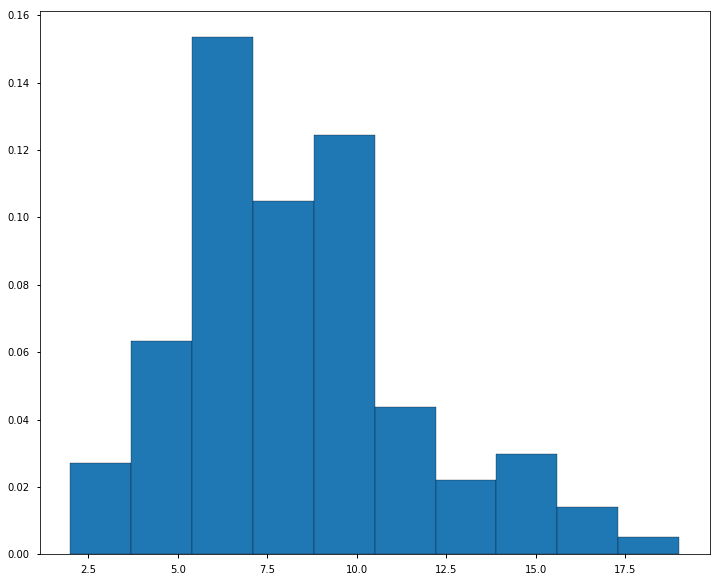

In [15]:
plt.subplots(figsize=(12,10))
plt.hist(lengths, normed=True,edgecolor='black')

In [16]:
def progress_print(s,target):
    global count
    count+=1
    if count%10==0:
        print(count)
#     print(s)
    return get_normalized_sentence_relation_vector(s,target)

In [17]:
count = 0
sentence_enchance_prob = [progress_print(x,[y]) for x,y in zip(sentence,sentence_target)]

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170


In [18]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [19]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')

In [20]:
#loading godin word embedding
def load_godin_word_embedding(path):
    print("Loading the model, this can take some time...")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [21]:
godin_model = load_godin_word_embedding("word_embeddings/word2vec_twitter_model.bin")

Loading the model, this can take some time...


In [22]:
def get_embedding_matrix(model,sentence,prob_vector,godin_flag = False):
    tokens = sentence.split()[:max_length]
    if godin_flag:
        embedding_matrix = np.zeros((max_length,400))
    else:
        embedding_matrix = np.zeros((max_length,300))
    for i,word in enumerate(tokens):
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
            embedding_matrix[i]*=prob_vector[i]
    return embedding_matrix

In [23]:
print("bulding word2vec matrix of data set")
sentence_word2vec = np.asarray([get_embedding_matrix(word2vec_model,x,y[0]) for x,y in zip(sentence,sentence_enchance_prob)])
print("bulding godin matrix of data set")
sentence_godin = np.asarray([get_embedding_matrix(godin_model,x,y[0],godin_flag=True) for x,y in zip(sentence,sentence_enchance_prob)])

bulding word2vec matrix of data set
bulding godin matrix of data set


In [857]:
# print("bulding word2vec matrix of data set")
# data_word2vec = np.asarray([get_embedding_matrix(word2vec_model,x) for x in dataX])
# print("bulding godin matrix of data set")
# data_godin = np.asarray([get_embedding_matrix(godin_model,x,godin_flag=True) for x in dataX])

In [36]:
def sk_mse(y_true,y_pred):
     return K.mean(K.square(y_pred - y_true), axis=-1)

In [37]:
def define_model(length,n_dense,dropout,learning_rate,n_filters,filter_size_c1,filter_size_c2,filter_size_c3,em_c1,em_c2,em_c3):
    # channel 1
    if em_c1 == 'embedding_matrix_word2vec':
        inputs1 = Input(shape=(length,300))
    else:
        inputs1 = Input(shape=(length,400))
#     if em_c1 == 'free':
#         embedding1 = Embedding(vocab_size, free_em_dim)(inputs1)
#     else:
#         embedding1 = Embedding(vocab_size, len(eval(em_c1)[0]), weights = [eval(em_c1)],input_length=length,trainable = em_trainable_flag)(inputs1)

    conv1 = Conv1D(filters=n_filters, kernel_size=filter_size_c1, activation='relu')(inputs1)
    drop1 = Dropout(dropout)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    if em_c2 == 'embedding_matrix_word2vec':
        inputs2 = Input(shape=(length,300))
    else:
        inputs2 = Input(shape=(length,400))
#     embedding2 = Embedding(vocab_size, 400, weights = [embedding_matrix_godin],input_length=length,trainable = em_trainable_flag)(inputs2)
#     if em_c2 == 'free':
#         embedding2 = Embedding(vocab_size, free_em_dim)(inputs2)
#     else:
#         embedding2 = Embedding(vocab_size, len(eval(em_c2)[0]), weights = [eval(em_c2)],input_length=length,trainable = em_trainable_flag)(inputs2)
    conv2 = Conv1D(filters=n_filters, kernel_size=filter_size_c2, activation='relu')(inputs2)
    drop2 = Dropout(dropout)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    if em_c1 == 'embedding_matrix_word2vec':
        inputs3 = Input(shape=(length,300))
    else:
        inputs3 = Input(shape=(length,400))
#     embedding3 = Embedding(vocab_size, 400)(inputs3)
#     if em_c3 == 'free':
#         embedding3 = Embedding(vocab_size, free_em_dim)(inputs3)
#     else:
#         embedding3 = Embedding(vocab_size, len(eval(em_c3)[0]), weights = [eval(em_c3)],input_length=length,trainable = em_trainable_flag)(inputs3)
    conv3 = Conv1D(filters=n_filters, kernel_size=filter_size_c3, activation='relu')(inputs3)
    drop3 = Dropout(dropout)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(n_dense, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[sk_mse])
    # summarize
#     print(model.summary())
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [38]:
model = define_model(length = max_length,
                         n_dense=400,
                         dropout=0.8675199417083123,
                         learning_rate=0.00997590314174646,
                         n_filters=100,
                         filter_size_c1=2,
                         filter_size_c2=3,
                         filter_size_c3=2,
                         em_c1='embedding_matrix_godin',
                         em_c2='embedding_matrix_word2vec',
                         em_c3='embedding_matrix_godin')

In [39]:
input_array_train = [sentence_godin,sentence_word2vec,sentence_godin]

In [40]:
trainY = score

In [41]:
history_object = model.fit(input_array_train,trainY,epochs=50, batch_size=64)

Epoch 1/50
1171/1171 [==============================] - 2s 2ms/step - loss: 0.8860 - sk_mse: 0.0568
Epoch 2/50
1171/1171 [==============================] - 1s 1ms/step - loss: 0.6930 - sk_mse: 0.0417
Epoch 3/50
1171/1171 [==============================] - 1s 1ms/step - loss: 0.6920 - sk_mse: 0.0424
Epoch 4/50
1171/1171 [==============================] - 1s 1ms/step - loss: 0.6912 - sk_mse: 0.0418
Epoch 5/50
1171/1171 [==============================] - 1s 1ms/step - loss: 0.6874 - sk_mse: 0.0403
Epoch 6/50
1171/1171 [==============================] - 1s 1ms/step - loss: 0.6902 - sk_mse: 0.0409
Epoch 7/50
1171/1171 [==============================] - 1s 1ms/step - loss: 0.6893 - sk_mse: 0.0398
Epoch 8/50
1171/1171 [==============================] - 1s 1ms/step - loss: 0.6848 - sk_mse: 0.0388
Epoch 9/50
1171/1171 [==============================] - 1s 1ms/step - loss: 0.6928 - sk_mse: 0.0418
Epoch 10/50
1171/1171 [==============================] - 1s 1ms/step - loss: 0.6934 - sk_mse: 0.0413

In [42]:
model.save("models/sentiment_model.h5")

## K-fold Validation

In [48]:
# kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [44]:
# cv_mse=[]
# cv_r2=[]

In [45]:
# for train,test in kfold.split(sentence,score):
#     model = define_model(length = max_length,
#                          n_dense=400,
#                          dropout=0.8675199417083123,
#                          learning_rate=0.00997590314174646,
#                          n_filters=100,
#                          filter_size_c1=2,
#                          filter_size_c2=3,
#                          filter_size_c3=2,
#                          em_c1='embedding_matrix_godin',
#                          em_c2='embedding_matrix_word2vec',
#                          em_c3='embedding_matrix_godin')
    
   
#     input_array_train = [sentence_godin[train],sentence_word2vec[train],sentence_godin[train]]
#     input_array_test = [sentence_godin[test],sentence_word2vec[test],sentence_godin[test]]
#     trainY = score[train]
#     testY = score[test]
#     history_object = model.fit(input_array_train,trainY,epochs=50, batch_size=64,verbose=1)
#     pred = model.predict(input_array_test)
#     pred_val = [x[0] for x in pred]
#     pred_val = rescale(pred_val,[0,1],[-1,1])
#     testY = rescale(testY,[0,1],[-1,1])
#     m = mean_squared_error(testY,pred_val)
#     r2 = r2_score(testY,pred_val)
#     print(m,r2)
#     cv_mse.append(m)
#     cv_r2.append(r2)

In [46]:
# print("%.5f (+/- %.5f)" % (np.mean(cv_mse), np.std(cv_mse)))

In [47]:
# print("%.5f (+/- %.5f)" % (np.mean(cv_r2), np.std(cv_r2)))

## Hyperparameter search

In [862]:
# para_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',name='learning_rate')

In [863]:
# para_dropout = Real(low=0.4, high=0.9,name = 'dropout')

In [864]:
# para_n_dense = Categorical(categories=[100,200,300,400], name='n_dense')

In [865]:
# para_n_filters = Categorical(categories=[100,200,300,400],name='n_filters')

In [866]:
# para_filter_size_c1 = Integer(low=1,high=6,name = 'filter_size_c1')
# # para_filter_size_c2 = Integer(low=1,high=6,name = 'filter_size_c2')
# para_filter_size_c3 = Integer(low=1,high=6,name = 'filter_size_c3')

In [867]:
# para_em_c1 = Categorical(categories=['embedding_matrix_godin','embedding_matrix_word2vec'],name='em_c1')
# para_em_c2 = Categorical(categories=['embedding_matrix_godin','embedding_matrix_word2vec'],name='em_c2')
# para_em_c3 = Categorical(categories=['embedding_matrix_godin','embedding_matrix_word2vec'],name='em_c3')

In [868]:
# para_batch_size = Categorical(categories=[8,16,32,64],name='batch_size')

In [869]:
# para_epoch = Categorical(categories=[10,20,30,50],name='epoch')

In [870]:
# parameters = [para_learning_rate,para_dropout,para_n_dense,para_n_filters,para_filter_size_c1,para_filter_size_c2,para_filter_size_c3,para_em_c1,para_em_c2,para_em_c3,para_batch_size,para_epoch]

In [871]:
# default_parameters = [0.0006973763486468701,0.9,400,300,1,1,1,'embedding_matrix_godin','embedding_matrix_word2vec','embedding_matrix_godin',8,10]

In [872]:
# record = dict()
# key=0

In [873]:
# @use_named_args(dimensions=parameters)
# def fitness(learning_rate,dropout,n_dense,n_filters,filter_size_c1,filter_size_c2,filter_size_c3,em_c1,em_c2,em_c3,batch_size,epoch):
# # n_dense,dropout,learning_rate,n_filters,filter_size_c1,filter_size_c2,filter_size_c3,em_c1,em_c2,em_c3,free_em_dim,em_trainable_flag
#     # Print the hyper-parameters.
#     global key
#     global record
#     print('-----------------------------combination no={0}------------------'.format(key))
#     print('learning rate ==>',learning_rate)
#     print('dropout==>',dropout)
#     print('n_dense==>',n_dense)
#     print('n_filters==>',n_filters)
#     print('filter_size_c1',filter_size_c1)
#     print('filter_size_c2',filter_size_c2)
#     print('filter_size_c3',filter_size_c3)
#     print('em_c1==>',em_c1)
#     print('em_c2==>',em_c2)
#     print('em_c3==>',em_c3)
#     print('batch_size==>',batch_size)
#     print('epocs==>',epoch)

    
#     cv_mse=[]
#     cv_r2=[]
#     for train,test in kfold.split(dataX,dataY):
#         model = define_model(length = max_length,
#                              n_dense=n_dense,
#                              dropout=dropout,
#                              learning_rate=learning_rate,
#                              n_filters=n_filters,
#                              filter_size_c1=int(filter_size_c1),
#                              filter_size_c2=int(filter_size_c2),
#                              filter_size_c3=int(filter_size_c3),
#                              em_c1=em_c1,
#                              em_c2=em_c2,
#                              em_c3=em_c3)
        
#         input_array_train = [data_word2vec[train] if x=='embedding_matrix_word2vec' else data_godin[train] for x in [em_c1,em_c2,em_c3]]
#         input_array_test = [data_word2vec[test] if x=='embedding_matrix_word2vec' else data_godin[test] for x in [em_c1,em_c2,em_c3]]
        
#         trainY = dataY[train]
#         testY = dataY[test]
        
#         history_object = model.fit(input_array_train,trainY,epochs=epoch, batch_size=batch_size)
#         pred = model.predict(input_array_test)
#         pred_val = [x[0] for x in pred]
#         pred_val = rescale(pred_val,[0,1],[-1,1])
#         testY = rescale(testY,[0,1],[-1,1])
#         m = mean_squared_error(testY,pred_val)
#         r2 = r2_score(testY,pred_val)
#         print(m,r2)
#         cv_mse.append(m)
#         cv_r2.append(r2)
#     mse_mean = np.mean(cv_mse)
#     r2_mean = np.mean(cv_r2)
#     print(cv_mse)
#     print(cv_r2)
#     print(mse_mean)
#     print(r2_mean)
    
#     record[key] = {'parameters':[learning_rate,dropout,n_dense,n_filters,filter_size_c1,filter_size_c2,filter_size_c3,em_c1,em_c2,em_c3,batch_size,epoch],'mse_mean':mse_mean,'r2_mean':r2_mean,'cv_mse':cv_mse,'cv_r2':cv_r2}
        
#     with open('models/record.json', 'w') as fout:
#         json.dump(record,fout,indent=4)
    
#     key+=1
    
#     del model
#     K.clear_session()
    
#     return -mse_mean

In [874]:
# search_result = gp_minimize(func=fitness,
#                             dimensions=parameters,
#                             acq_func='EI',
#                             n_calls=11,
#                             x0=default_parameters)

In [875]:
# print("traning done")